In [1]:
import pandas as pd
from utils.text import plot_wordclouds
import seaborn as sns

In [2]:
binary=False

# Carregando dados de an√°lise

In [3]:
data_df = pd.read_csv("/home/kenzosaki/mestrado/data/tweetsentbr/tweetsentbr_test.csv", index_col=0)

In [4]:
id2label = {
    0: "neutro",
    1: "positivo",
    2: "negativo"
}

In [5]:
# Convertendo ids para labels para facilitar interpreta√ß√£o
data_df["label"] = data_df["label"].map(id2label)

In [6]:
data_df.head()

label                                               text
2403  positivo           Come√ßou o The Noite com o Charlie Hunnam
1349  negativo  No twitter a 3¬™ feira √© chata,pois todo mundo ...
5422    neutro     Bial declamando os do gar√ßom Conversa Com Bial
1262    neutro                 AI MEU DEUS √â AGORA Master Chef BR
5438  negativo  A Miriam s√≥ n√£o roda pq eu acho que o tal sorv...

In [7]:
# Para focar a an√°lise em apenas duas classes: positivo e negativo
if binary:
    data_df = data_df[data_df["label"] != "neutro"]

# Definindo procedimento de pre-processamento de texto

Pipeline simples de pre-processamento de texto, incluindo: convers√£o para lower-case, remo√ß√£o de stop-words, remo√ß√£o de hashtags e lemmatiza√ß√£o. Feito o processamento, o documento √© convertido para uma representa√ß√£o densa utilizando *word embeddings*. O spaCy utiliza embeddings FastText de 300 dimens√µes para representar seus tokens. Assim, textos ser√£o representados por 300 dimens√µes, que correspondem a m√©dia das *word embeddings* dos seus tokens. 

- Obs: Tokens que n√£o est√£o no vocabul√°rio das embeddings pre-treinadas s√£o representadas como vetores de zeros.

In [8]:
import spacy
import numpy as np
nlp = spacy.load("pt_core_news_md")

In [9]:
t = nlp("qdhiuweui frase de teste")

In [11]:
a.vector

array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0.

In [12]:
from typing import Iterable

def convert_text_to_vector(text: str) -> Iterable[str]:

    tokens = nlp(text)

    text_vector = np.zeros(300)
    used_tokens = 0

    for token in tokens:

        lemma = token.lemma_

        if token.is_stop: continue              # remo√ß√£o de stop-words
        if token.is_punct: continue             # remo√ß√£o de pontua√ß√£o
        if len(lemma.strip()) == 0: continue    # ignorar tokens "vazios"
        if "@" in lemma: continue               # remo√ß√£o simples de hashtags

        text_vector += token.vector
        used_tokens += 1
    
    return text_vector / used_tokens

# Convers√£o dos textos para representa√ß√µes densas

In [13]:
from sklearn.preprocessing import normalize

In [14]:
# Convers√£o para representa√ß√µes densas
text_vectors = [convert_text_to_vector(text) for text in data_df["text"]]

In [28]:
# Normaliza√ß√£o L2 para gera√ß√£o de vetores unit√°rios
text_vectors = normalize(text_vectors)

# Agrupamento usando K-means

In [29]:
from sklearn.cluster import KMeans
from tqdm import tqdm

In [30]:
# Quantidades de clusters para avaliar
n_clusters = list(range(2,11))
n_clusters

[2, 3, 4, 5, 6, 7, 8, 9, 10]

In [31]:
fitted_models = []
for k in tqdm(n_clusters):
    
    kmeans = KMeans(n_clusters=k, n_init=100, init='random', max_iter=500)
    kmeans.fit(text_vectors)

    fitted_models.append(kmeans)

100%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà| 9/9 [00:11<00:00,  1.28s/it]


# Avaliando silhueta dos agrupamentos gerados

In [32]:
from sklearn.metrics import silhouette_samples, silhouette_score
from yellowbrick.cluster.silhouette import silhouette_visualizer
import numpy as np
import matplotlib.pyplot as plt

In [33]:
%matplotlib inline

In [34]:
sns.set(rc={'figure.figsize':(15,6)})

In [35]:
silhouettes = [silhouette_score(text_vectors, kmeans.labels_) for kmeans in fitted_models]
inertias = [kmeans.inertia_ for kmeans in fitted_models]

Text(0.5, 0, 'Number of clusters')

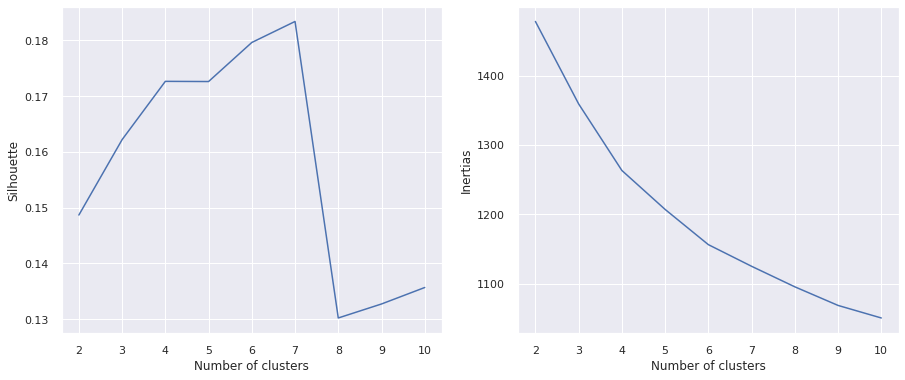

In [36]:
fig, axes = plt.subplots(1,2)

ax = sns.lineplot(x=n_clusters, y=silhouettes, ax=axes[0])
ax.set_ylabel("Silhouette")
ax.set_xlabel("Number of clusters")

ax = sns.lineplot(x=n_clusters, y=inertias, ax=axes[1])
ax.set_ylabel("Inertias")
ax.set_xlabel("Number of clusters")

In [37]:
# Escolhendo o modelo de maior silhueta mpedia para an√°lise
kmeans = fitted_models[np.argmax(silhouettes)]

In [38]:
data_df["silhouette"] = silhouette_samples(text_vectors, kmeans.labels_)
data_df["cluster"] = kmeans.labels_

In [39]:
mean_silh = data_df["silhouette"].mean()

In [40]:
print(f"- EE: {kmeans.inertia_}")
print(f"- Mean silhouette: {mean_silh}")

- EE: 1124.8796182801818
- Mean silhouette: 0.1833810935051064


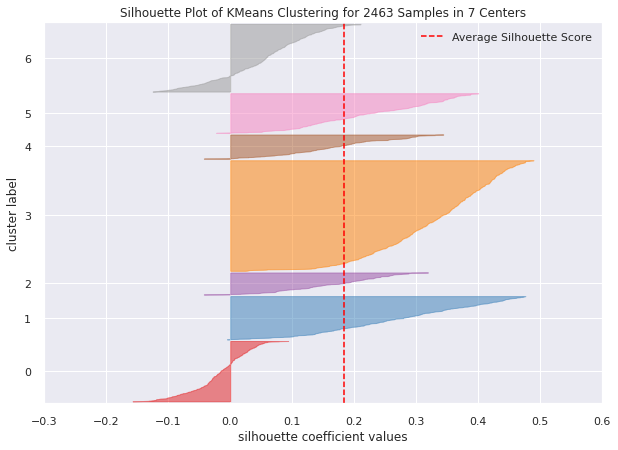

SilhouetteVisualizer(ax=<matplotlib.axes._subplots.AxesSubplot object at 0x7f8d2cc70cd0>,
                     estimator=KMeans(init='random', max_iter=500, n_clusters=7,
                                      n_init=100))

In [41]:
sns.set(rc={'figure.figsize':(10,7)})
silhouette_visualizer(
    kmeans,
    X=text_vectors,
    y=data_df["label"].values,
    is_fitted=True
)

# Compara√ß√£o entre clusters

Comparando pares de clusters, com rela√ß√£o as classes (positivo, neutro ou negativo) e palavras frequentes.

In [51]:
cluster_pair = (1, 3)

In [52]:
c0_df = data_df[data_df["cluster"] == cluster_pair[0]]
c1_df = data_df[data_df["cluster"] == cluster_pair[1]]

# Distribui√ß√£o de classes por cluster

In [53]:
order = ["positivo", "negativo"] if binary else \
        ["positivo", "neutro", "negativo"]

Text(0.5, 0, 'Cluster 3')

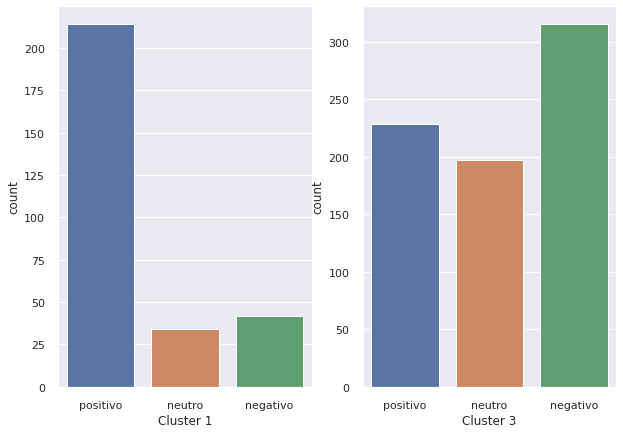

In [54]:
fig, axes = plt.subplots(1,2)

sns.countplot(data=c0_df, x="label", ax=axes[0], order=order)
axes[0].set_xlabel(f"Cluster {cluster_pair[0]}")
sns.countplot(data=c1_df, x="label", ax=axes[1], order=order)
axes[1].set_xlabel(f"Cluster {cluster_pair[1]}")

## Wordclouds por cluster

Gerando nuvens de palavras para cluster do par em an√°lise.

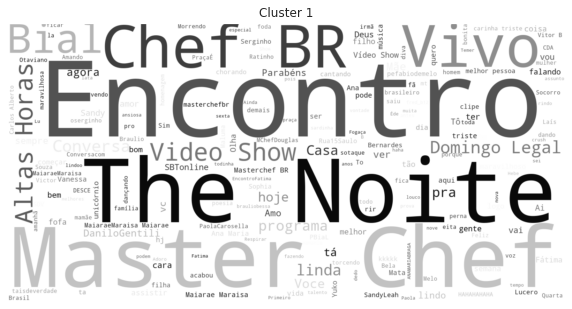

In [55]:
plot_wordclouds(
    text=" ".join(c0_df["text"].values.tolist()),
    title=f"Cluster {cluster_pair[0]}",
    colormap="binary", 
    background_color='white',
    max_words=200,
    width=1600, height=800
)

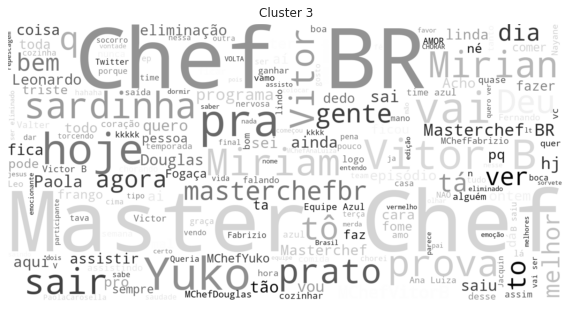

In [56]:
plot_wordclouds(
    text=" ".join(c1_df["text"].values.tolist()),
    title=f"Cluster {cluster_pair[1]}",
    colormap="binary", 
    background_color='white',
    max_words=200,
    width=1600, height=800
)

# Visualizando exemplos de maior silhueta por cluster

In [57]:
cluster = 1

In [58]:
c_df = data_df[data_df["cluster"] == cluster]

In [59]:
pd.set_option('max_colwidth', None)
c_df.sort_values(by="silhouette", ascending=False).head(10)

label  \
517   positivo   
9420  positivo   
8878    neutro   
982   positivo   
9115  positivo   
1322  positivo   
897   positivo   
9427  positivo   
5028  positivo   
4243  positivo   

                                                                                text  \
517     encontro anos s√≥ de carreira. √â muito talento. √â muita hist√≥ria üòçüòçüòçüòçüòçüòçüòçüòçüòçüòçüòçüòç   
9420                                 "Eu quero descer!!!" üòÇüòÇüòÇüòÇüòÇüòÇüòÇüòÇüòÇüòÇüòÇüòÇüòÇüòÇüòÇüòÇ The Noite   
8878                               S√£o muito lokas!!!!!!!! üòÇüòÇüòÇüòÇüòÇüòÇüòÇ Conversa Com Bial   
982                                     Que show de violino no Encontro üëèüèªüëèüèªüëèüèªüëèüèªüëèüèªüëèüèª   
9115  Coisa mais linda essa edi√ß√£o com a m√£e do @oserginho !!!!! üòçüòçüòçüòçüíóüíóüíóüíóaltas horas   
1322                                  Esses caras do The Noite s√£o foda üòÇüòÇüòÇüòÇüòÇüòÇüòÇüòÇüòÇüòÇüòÇüòÇ   
897           O Diguinho sensualizando com a perna üòÇüòÇüòÇüòÇüòÇüòÇüòÇüòÇüòÇ The Noite Mestre Mandou   
9427          üòÇüòÇüòÇüòÇüòÇüòÇüòÇüòÇ gosto quando o programa √© ao vivo e tem conflitos!!! Encontro   
5028                                  O L√©o carregando o Danilo üòÇüòÇüòÇüòÇüòÇüòÇüòÇüòÇüòÇüòÇ The Noite   
4243                               Ana Maria Braga, melhor pessoa üòÇüòÇüòÇüòÇüòÇüòÇüòÇüòÇ Mais Voce   

      silhouette  cluster  
517     0.476102        1  
9420    0.474250        1  
8878    0.473854        1  
982     0.473174        1  
9115    0.472538        1  
1322    0.471367        1  
897     0.467986        1  
9427    0.467848        1  
5028    0.466079        1  
4243    0.462968        1